$^*$ If you don’t have a LaTeX package installed for Python, feel free to modify the plot legends and titles accordingly.

In [1]:
import os
import sys
sys.path.insert(0, '../src') 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.datasets import load_svmlight_file
import numpy as np
from numpy.linalg import norm

from methods import *
from oracles import *
from utils import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## LogSumExp

Objective function:

$$
\min\limits_{\boldsymbol{x} \in \mathbb{R}^n} f(x) = \mu \sum\limits_{i=1}^{n} \exp\left(\frac{\langle \boldsymbol{a}_i, \boldsymbol{x}\rangle - b_i}{\mu}\right) \approx \max\limits_{1\leq i\leq n} \left[ \langle \boldsymbol{a}_i, \boldsymbol{x} \rangle - b_i \right], \,\,\, \mu > 0.
$$

Approximation (Weighted Gauss-Newton in the paper):

$$
\mathbf{H}(\boldsymbol{x})  = \frac{1}{\mu}\mathbf{A}^\top\operatorname{Diag}\left(\mathrm{softmax}\left(\mathbf{A}, \boldsymbol{x}\right)\right)\mathbf{A}, \;\;\; \left[\mathrm{softmax}\left(\mathbf{A}, \boldsymbol{x}\right)\right]_k = \frac{\exp\left((\langle \boldsymbol{a}_k, \boldsymbol{x}\rangle - b_k) / \mu\right)}{\sum\limits_{j=1}^n \exp\left((\langle \boldsymbol{a}_j, \boldsymbol{x}\rangle - b_j) / \mu\right)},
$$

where $\boldsymbol{a}_1, \dots \boldsymbol{a}_n$ are rows of matrix $\mathbf{A}$.

In [2]:
def approx_hess_fn_logsumexp(approx_oracle, x_k):
    """
    Weighted Gauss-Newton approximation: 
    H = (A^T (diag(pi)) A) / mu
    """
    approx_oracle._update_a_and_pi(x_k)
    pi = approx_oracle.pi
    return approx_oracle.matmat_ATsA(pi) / approx_oracle.mu

In [3]:
n = 1000 # Dimension
m = 1000 # Number of linear functions
mu = 1.0 # Smoothing parameter
np.random.seed(3124)
A = np.random.rand(n, m) * 2 - 1 # design matrix
b = np.random.rand(m) * 2 - 1 # labels
oracle = create_log_sum_exp_zero_oracle(A.T, b, mu) # logsumexp oracle
f_star = oracle.func(np.zeros(n)) # Optimum is at zero
x_0 = np.ones(n) # Initial point
B = A.dot(A.T) # The matrix for the Euclidean metric
Binv = np.linalg.inv(B) # The inverse matrix for the Euclidean metric
eps = 1e-8 # Functional residual tolerance
H_min = 1e-9 # The minimal value of regularization constant

In [4]:
_, msg, exact_GNS_logsumexp = grad_norm_smooth(oracle, x_0, 
                                    n_iters=1000, 
                                    gamma_0=1.0, 
                                    adaptive_search=True,
                                    is_approx=False,
                                    approx_oracle=oracle,
                                    approx_hess_fn=approx_hess_fn_logsumexp,
                                    B=B, 
                                    Binv=Binv,
                                    f_star=f_star,
                                    eps=eps,
                            )
print('Time: %.3f s' % exact_GNS_logsumexp['time'][-1])



_, msg, inexact_GNS_logsumexp = grad_norm_smooth(oracle, x_0, 
                                    n_iters=1000, 
                                    gamma_0=1.0, 
                                    adaptive_search=True,
                                    is_approx=True,
                                    approx_oracle=oracle,
                                    approx_hess_fn=approx_hess_fn_logsumexp,
                                    B=B, 
                                    Binv=Binv,
                                    f_star=f_star,
                                    eps=eps,
                            )
print('Time: %.3f s' % inexact_GNS_logsumexp['time'][-1])


_, msg, GN_logsumexp = gradient_method(oracle, x_0, 
                                     max_iter=1000, 
                                     L_0=1.0,
                                     B=B, 
                                     Binv=Binv, 
                                     line_search=True)
print('Time: %.3f s' % GN_logsumexp['time'][-1])


_, msg, GM_logsumexp = gradient_method(oracle, x_0, 
                                     max_iter=1000, 
                                     L_0=1.0,
                                     B=None, 
                                     Binv=None, 
                                     line_search=True)
print('Time: %.3f s' % GM_logsumexp['time'][-1])

Time: 29.012 s
Time: 83.920 s
Time: 3.937 s
Time: 1.962 s


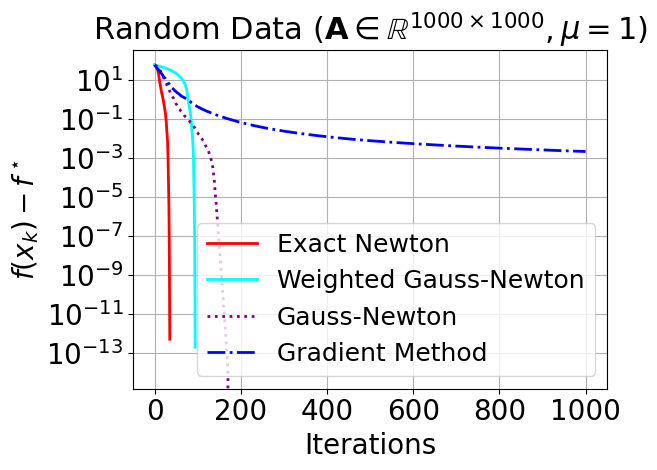

In [5]:
plt.semilogy(np.array(exact_GNS_logsumexp['func']) - f_star, 
             linewidth=2, label=r"Exact Newton", color='red', linestyle='-')
plt.semilogy(np.array(inexact_GNS_logsumexp['func']) - f_star, 
             linewidth=2, label=r"Weighted Gauss-Newton", color='cyan', linestyle='-')
plt.semilogy(np.array(GN_logsumexp['func']) - f_star,
             linewidth=2, label=r"Gauss-Newton", color='purple', linestyle='dotted')
plt.semilogy(np.array(GM_logsumexp['func']) - f_star,
             linewidth=2, label=r"Gradient Method", color='blue', linestyle='-.')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$f(x_k) - f^\star$', fontsize=20)
plt.title(r"Random Data ($\mathbf{A} \in \mathbb{R}^{%d \times %d}, \mu = %.0f$)" % (m, n, mu), fontsize=22)
plt.grid(True)
plt.tight_layout()

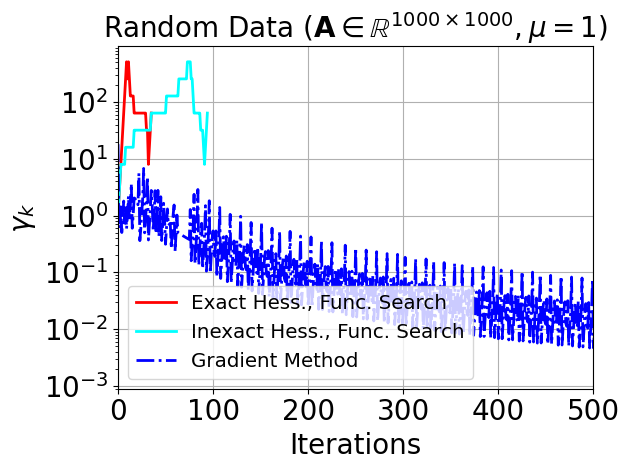

In [6]:
plt.semilogy(np.array(exact_GNS_logsumexp['gamma_k']), '-', 
             linewidth=2, label=r"Exact Hess., Func. Search", color='red')
plt.semilogy(np.array(inexact_GNS_logsumexp['gamma_k']), '-' ,
             linewidth=2, label=r"Inexact Hess., Func. Search", color='cyan')
plt.semilogy(np.array(GM_logsumexp['grad_sqr_norm'])**0.5 / np.array(GM_logsumexp['L']),
             linewidth=2, label=r"Gradient Method", color='blue', linestyle='-.')

plt.xlim([0, 500])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=14.3)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r"$\gamma_k$", fontsize=20)
plt.title(r"Random Data ($\mathbf{A} \in \mathbb{R}^{%d \times %d}, \mu = %.0f$)" % (m, n, mu), fontsize=20)
plt.grid(True)
plt.tight_layout()

## Inexact Hessian for linear operators

Objective function:

$$
\min\limits_{\boldsymbol{x} \in \mathbb{R}^n} f(x) = \frac{1}{p} \| \boldsymbol{u}(\boldsymbol{x}) \|,
$$

where $\boldsymbol{u}(\boldsymbol{x}) = \mathbf{A}\boldsymbol{x} - \boldsymbol{b}$ a linear oparator.

Approximation (Fisher Term of $\mathbf{H}$ in the paper):

$$
\mathbf{H}(\boldsymbol{x}) = \frac{p-2}{\| \boldsymbol{u}(\boldsymbol{x}) \|^p} \nabla f(\boldsymbol{x}) \nabla f(\boldsymbol{x})^\top.
$$

In [7]:
def approx_hess_fn_fisher_term(oracle, x):
    """
    Approximate Hessian of f(x)=1/p||u(x)||^p by the Fisher term:
      (p-2)||u||^{p-4}(J^T u)(J^T u)^T
    """
    u = oracle.func_u(x)
    norm_u = np.linalg.norm(u)
    J = oracle.jac_u(x)
    H_approx = np.zeros((x.shape[0], x.shape[0]))
    if oracle.p != 2:
        g = J.T.dot(u)
        H_approx += (oracle.p - 2) * norm_u**(oracle.p - 4) * np.outer(g, g)
    return H_approx

In [8]:
n = 100 # Dimension
m = 200 # Number of linear inequalities
p = 4 # Degree
np.random.seed(3124)
A = np.random.rand(n, m) * 2 - 1
b = np.random.rand(n) * 2 - 1
oracle = NonlinearEquationsOracle(p, A=A, b=b) # Nonlinear Equations oracle
x_0 = np.ones(m) # Initial point
eps = 1e-8
B = A.T.dot(A) + eps * np.eye(A.shape[1])
Binv = np.linalg.inv(B)

In [9]:
_, msg, exact_GNS_equations = grad_norm_smooth(oracle, x_0, 
                                    n_iters=100, 
                                    gamma_0=1.0, 
                                    adaptive_search=True,
                                    is_approx=False,
                                    approx_oracle=oracle,
                                    approx_hess_fn=None,
                                    B=B, 
                                    Binv=Binv,
                                    eps=eps,
                            )
print('Time: %.3f s' % exact_GNS_equations['time'][-1])


_, msg, inexact_GNS_equations = grad_norm_smooth_for_rank_one(oracle, x_0, 
                                    n_iters=100, 
                                    gamma_0=1.0, 
                                    adaptive_search=True,
                                    is_approx=True,
                                    approx_oracle=oracle,
                                    approx_hess_fn=approx_hess_fn_fisher_term,
                                    invert_backend='wsm', # use Woodbury-Sherman-Morrison formula for fast inversion
                                    B=B, 
                                    Binv=Binv, # do not use Binv in order to track time correctly
                                    eps=eps,
                            )
print('Time: %.3f s' % inexact_GNS_equations['time'][-1])


_, msg, GN_equations = gradient_method(oracle, x_0, 
                                     max_iter=200, 
                                     L_0=1.0,
                                     B=B,
                                     Binv=None, # do not use Binv in order to track time correctly
                                     line_search=True)
print('Time: %.3f s' % GN_equations['time'][-1])


_, msg, GM_equations = gradient_method(oracle, x_0, 
                                     max_iter=200, 
                                     L_0=1.0,
                                     B=None,
                                     Binv=None,
                                     line_search=True)
print('Time: %.3f s' % GM_equations['time'][-1])

Time: 442.007 s
Time: 0.910 s
Time: 0.029 s
Time: 0.015 s


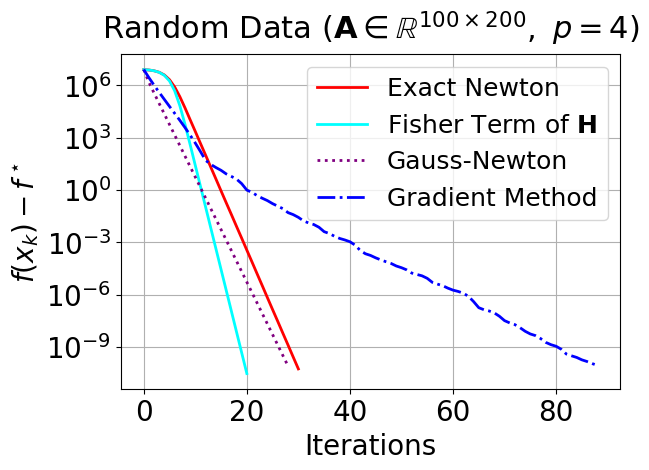

In [10]:
mn_func = min(
    np.min(exact_GNS_equations['func']),
    np.min(inexact_GNS_equations['func']),
    np.min(GN_equations['func']),
    np.min(GM_equations['func']),
)

plot_only_iterations(
    histories=[
        exact_GNS_equations,
        inexact_GNS_equations,
        GN_equations,
        GM_equations,
        ],
    labels=[
        r"Exact Newton", 
        r"Fisher Term of $\mathbf{H}$", 
        r"Gauss-Newton",
        r"Gradient Method",
    ],
    f_star=mn_func,
    colors=[
        'red', 
        'cyan',
        'purple', 
        'blue',
    ],
    linewidths=[2, 2, 2, 2],
    linestyles=['-', '-', 'dotted', '-.'],
    threshold=1e-10,
    max_iter=100,
    title=r"Random Data ($\mathbf{A} \in \mathbb{R}^{%d \times %d},\ p = %.0f$)" % (A.shape[0], A.shape[1], p),
)

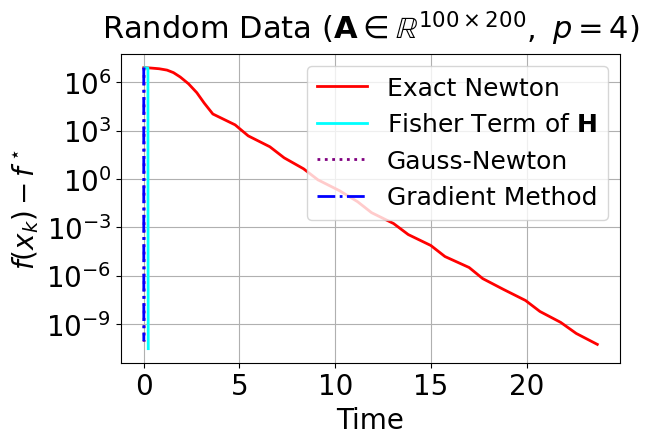

In [11]:
mn_func = min(
    np.min(exact_GNS_equations['func']),
    np.min(inexact_GNS_equations['func']),
    np.min(GN_equations['func']),
    np.min(GM_equations['func']),
)

plot_only_time(
    histories=[
        exact_GNS_equations,
        inexact_GNS_equations,
        GN_equations,
        GM_equations,
        ],
    labels=[
        r"Exact Newton", 
        r"Fisher Term of $\mathbf{H}$", 
        r"Gauss-Newton",
        r"Gradient Method",
    ],
    f_star=mn_func,
    colors=[
        'red', 
        'cyan',
        'purple',
        'blue',
    ],
    linewidths=[2, 2, 2, 2],
    linestyles=['-', '-', 'dotted', '-.'],
    threshold=1e-10,
    max_iter=100,
    title=r"Random Data ($\mathbf{A} \in \mathbb{R}^{%d \times %d},\ p = %.0f$)" % (A.shape[0], A.shape[1], p),
)

## Rosenbrock function and Chebyshev polynomials

Objective function:

$$
\min\limits_{\boldsymbol{x} \in \mathbb{R}^n} f(x) = (a - x_1)^2 + b (x_2 - x_1^2)^2, \;\;\; \boldsymbol{x} = \left(x_1, x_2\right)^\top.
$$

We do not apply the approximation in the case of the standard 2D Rosenbrock function.

In [12]:
np.random.seed(3124)
oracle = RosenbrockOracle(a=1.0, b=100.0) # Rosenbrock oracle
eps = 1e-8
x_0 = np.array([-2.0, 2.0]) #  Starting point, some points in the vicinity of optimum may lead to numerical issues
x_star = np.array([1.0, 1.0]) #  Optimum
f_star = oracle.func(x_star) #  zero

In [ ]:
_, msg, GNS_rosenbrock = grad_norm_smooth(
    oracle,
    x_0,
    n_iters=60,
    gamma_0=1.0,
    adaptive_search=True,
    is_approx=False,
    approx_oracle=oracle,
    approx_hess_fn=None,
    B=None,
    Binv=None,
    eps=eps,
)
print('Time: %.3f s' % GNS_rosenbrock['time'][-1])


_, msg, GM_rosenbrock = gradient_method(oracle, x_0, 
                                     max_iter=5000, 
                                     L_0=1.0,
                                     B=None,
                                     Binv=None,
                                     line_search=True)
print('Time: %.3f s' % GM_rosenbrock['time'][-1])

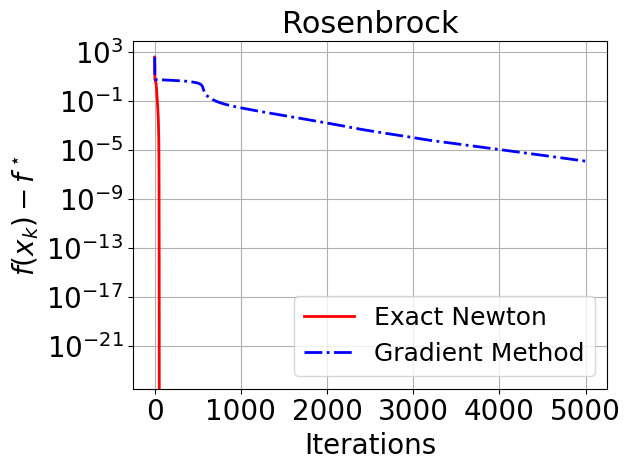

In [14]:
plt.semilogy(np.array(GNS_rosenbrock['func']) - f_star, 
             linewidth=2, label=r"Exact Newton", color='red', linestyle='-')
plt.semilogy(np.array(GM_rosenbrock['func']) - f_star, 
             linewidth=2, label=r"Gradient Method", color='blue', linestyle='-.')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$f(x_k) - f^\star$', fontsize=20)
plt.title(r"Rosenbrock", fontsize=22)
plt.grid(True)
plt.tight_layout()

Objective function:

$$
\min\limits_{\boldsymbol{x} \in \mathbb{R}^n} f(x) = \frac{1}{p} \| \boldsymbol{u}(\boldsymbol{x}) \|,
$$

where $\boldsymbol{u}(\boldsymbol{x}) = \left(1 - x_1, \,\,\, 10(x_2 - x_1^2)\right)^\top.$

Approximation (just Inexact Hessian in the paper):

$$
\mathbf{H}(\boldsymbol{x}) = \| \boldsymbol{u}(\boldsymbol{x}) \|^{p - 2} \nabla \boldsymbol{u}(\boldsymbol{x})^\top \mathbf{B} \nabla \boldsymbol{u}(\boldsymbol{x}) + \frac{p - 2}{\| \boldsymbol{u}(\boldsymbol{x}) \|^p} \nabla f(\boldsymbol{x}) \nabla f(\boldsymbol{x})^{\top}.
$$

We set $\mathbf{B} \equiv \mathbf{I}$ in the following practical example.

In [15]:
def approx_hess_nonlinear_equations(oracle, x):
    """
    Approximate Hessian of f(x)=1/p||u(x)||^p as out theory suggests:
    H = (||u||^{p-2} J^T J) + (p-2)(||u||^{p-4} (J^T u)(J^T u)^T)
    where J is the Jacobian of u(x).
    """
    u, J = oracle._compute_u_and_jac(x)
    norm_u = np.linalg.norm(u)
    p = oracle.p
    if norm_u == 0:
            return (norm_u ** (p - 2)) * (J.T.dot(J))
    H = (norm_u ** (p - 2)) * (J.T.dot(J))
    if p != 2:
            Ju = J.T.dot(u)                    
            outer_term = np.outer(Ju, Ju)     
            H += (p - 2) * (norm_u ** (p - 4)) * outer_term

    return H

In [16]:
p = 5
oracle = NonlinearEquationsRosenbrockOracle(p=p, a=1.0, b=100.0) # Nonlinear Equations Rosenbrock oracle
eps = 1e-8
np.random.seed(3124)
x_0 = np.array([-2.0, 2.0]) #  Starting point, some points in the vicinity of optimum may lead to numerical issues
x_star = np.array([1.0, 1.0])
f_star = oracle.func(x_star)

In [17]:
_, msg, exact_GNS_nonlinrosenbrock = grad_norm_smooth(
    oracle,
    x_0,
    n_iters=100,
    gamma_0=1.0,
    adaptive_search=True,
    is_approx=False,
    approx_oracle=oracle,
    approx_hess_fn=None,
    B=None,
    Binv=None,
    eps=eps,
)
print('Time: %.3f s' % exact_GNS_nonlinrosenbrock['time'][-1])


_, msg, inexact_GNS_nonlinrosenbrock = grad_norm_smooth(
    oracle,
    x_0,
    n_iters=100,
    gamma_0=1.0,
    adaptive_search=True,
    is_approx=True,
    approx_oracle=oracle,
    approx_hess_fn=approx_hess_nonlinear_equations,
    B=None,
    Binv=None,
    eps=eps,
)
print('Time: %.3f s' % inexact_GNS_nonlinrosenbrock['time'][-1])


_, msg, GM_nonlinrosenbrock = gradient_method(oracle, x_0, 
                                     max_iter=10000, 
                                     L_0=1.0,
                                     B=None,
                                     Binv=None,
                                     line_search=True)
print('Time: %.3f s' % GM_nonlinrosenbrock['time'][-1])

Time: 0.009 s
Time: 0.008 s
Time: 0.203 s


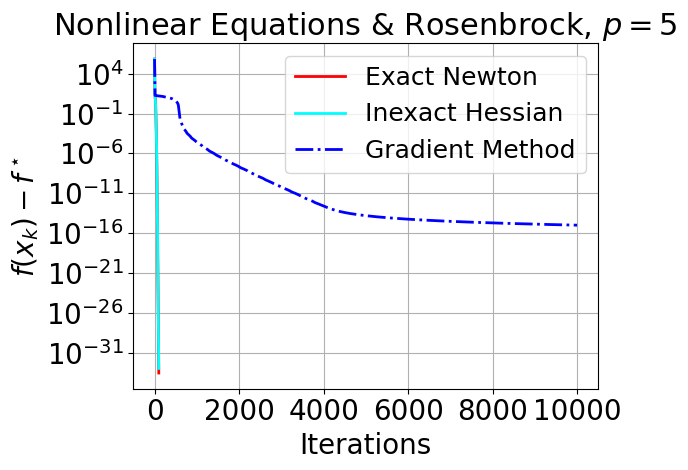

In [18]:
plt.semilogy(np.array(exact_GNS_nonlinrosenbrock['func']) - f_star, 
             linewidth=2, label=r"Exact Newton", color='red', linestyle='-')
plt.semilogy(np.array(inexact_GNS_nonlinrosenbrock['func']) - f_star, 
             linewidth=2, label=r"Inexact Hessian", color='cyan', linestyle='-')
plt.semilogy(np.array(GM_nonlinrosenbrock['func']) - f_star, 
             linewidth=2, label=r"Gradient Method", color='blue', linestyle='-.')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$f(x_k) - f^\star$', fontsize=20)
plt.title(r"Nonlinear Equations & Rosenbrock, $p=%d$" % (p), fontsize=22)
plt.grid(True)
plt.tight_layout()

Objective function:

$$
\min\limits_{\boldsymbol{x} \in \mathbb{R}^n} f(x) = \frac{1}{p} \| \boldsymbol{u}(\boldsymbol{x}) \|,
$$

where $\boldsymbol{u}(\boldsymbol{x}) = \left(u_1, \dots, u_d\right)^\top$, such that

$u_1(\boldsymbol{x}) = \frac12 \left(1 - x_1\right), \quad u_i(\boldsymbol{x}) = x_i - \mathrm{p}_2(x_{i-1}), \quad \mathrm{p}_2(\tau) = 2\tau^2 - 1.$

Here, $\mathrm{p}_2$ is the Chebyshev polynomial of degree two.

Approximation (just Inexact Hessian in the paper):

$$
\mathbf{H}(\boldsymbol{x}) = \| \boldsymbol{u}(\boldsymbol{x}) \|^{p - 2} \nabla \boldsymbol{u}(\boldsymbol{x})^\top \mathbf{B} \nabla \boldsymbol{u}(\boldsymbol{x}) + \frac{p - 2}{\| \boldsymbol{u}(\boldsymbol{x}) \|^p} \nabla f(\boldsymbol{x}) \nabla f(\boldsymbol{x})^{\top}.
$$

We set $\mathbf{B} \equiv \mathbf{I}$ in the following practical example.

In [19]:
def approx_hess_fn_chebyshev(oracle, x):
    """
    Approximate Hessian of f(x)=1/p||u(x)||^p as out theory suggests:
    H = (||u||^{p-2} J^T J) + (p-2)(||u||^{p-4} (J^T u)(J^T u)^T)
    where J is the Jacobian of u(x).
    """
    u = oracle.func_u(x)
    norm_u = np.linalg.norm(u)
    J = oracle.jac_u(x)
    if norm_u == 0:
        if oracle.p == 2:
            return J.T.dot(J)
        else:
            return np.zeros((oracle.n, oracle.n), dtype=float)

    p = oracle.p
    H_approx = (norm_u ** (p - 2)) * (J.T.dot(J))
    if p != 2:
        g_vec = J.T.dot(u)
        H_approx += (p - 2) * (norm_u ** (p - 4)) * np.outer(g_vec, g_vec)

    return H_approx


In [20]:
np.random.seed(3124)
p = 4 # power in the Nonlinear Equations problem
n = 1000 # dimension of x
oracle = ChebyshevOracle(n, p) # Chebyshev oracle
x_0 = np.random.rand(n)
f_star = oracle.func(np.ones(n))
eps = 1e-8

In [21]:
_, msg, exact_su_chebyshev = super_newton(oracle, x_0, 
                                    n_iters=100, 
                                    H_0=1.0,
                                    alpha=1.0, 
                                    adaptive_search=True,
                                    B=None,
                                    Binv=None,
                                    eps=1e-8,
                            )
print('Time: %.3f s' % exact_su_chebyshev['time'][-1])


_, msg, inexact_GNS_chebyshev = grad_norm_smooth(
    oracle,
    x_0,
    n_iters=100,
    gamma_0=1.0,
    adaptive_search=True,
    is_approx=True,
    approx_oracle=oracle,
    approx_hess_fn=approx_hess_fn_chebyshev,
    B=None,
    Binv=None,
    eps=eps,
)
print('Time: %.3f s' % inexact_GNS_chebyshev['time'][-1])


_, msg, GM_chebyshev = gradient_method(oracle, x_0, 
                                     max_iter=200, 
                                     L_0=1.0,
                                     B=None,
                                     Binv=None,
                                     line_search=True)
print('Time: %.3f s' % GM_chebyshev['time'][-1])

Time: 328.608 s
Time: 87.134 s
Time: 1.207 s


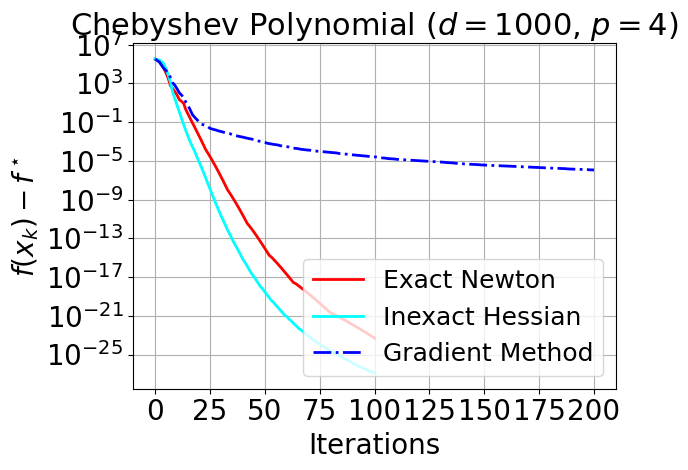

In [22]:
plt.semilogy(np.array(exact_su_chebyshev['func']) - f_star, 
             linewidth=2, label=r"Exact Newton", color='red', linestyle='-')
plt.semilogy(np.array(inexact_GNS_chebyshev['func']) - f_star, 
             linewidth=2, label=r"Inexact Hessian", color='cyan', linestyle='-')
plt.semilogy(np.array(GM_chebyshev['func']) - f_star, 
             linewidth=2, label=r"Gradient Method", color='blue', linestyle='-.')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$f(x_k) - f^\star$', fontsize=20)
plt.title(r"Chebyshev Polynomial ($d = %d$, $p = %d$)" % (n, p), fontsize=22)
plt.grid(True)
plt.tight_layout()